In [1]:
# install the libraries – see: http://biom-format.org/
!pip install biom-format
!pip install h5py
!pip install fbprophet
!wget https://github.com/twbattaglia/MicrobeDS/raw/master/data-raw/MovingPictures/67_otu_table.biom
!wget https://raw.githubusercontent.com/twbattaglia/MicrobeDS/master/data-raw/MovingPictures/550_prep_72_qiime_20161216-085930.txt

# will disable "future warnings"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import biom

biom_data = biom.load_table('67_otu_table.biom')
meta_df = pd.read_csv('550_prep_72_qiime_20161216-085930.txt', sep='\t')

--2020-01-11 20:55:22--  https://github.com/twbattaglia/MicrobeDS/raw/master/data-raw/MovingPictures/67_otu_table.biom
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/twbattaglia/MicrobeDS/master/data-raw/MovingPictures/67_otu_table.biom [following]
--2020-01-11 20:55:23--  https://raw.githubusercontent.com/twbattaglia/MicrobeDS/master/data-raw/MovingPictures/67_otu_table.biom
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13390177 (13M) [application/octet-stream]
Saving to: ‘67_otu_table.biom.4’

67_otu_table.biom.4 100%[===================>]  12.77M  23.2MB/s    in 0.5s    

2020-01-11 20:55:2

In [2]:
# convert the biom data to a data-frame
# this might takes some minutes for larger files
biom_df = biom_data.to_dataframe()
biom_df = biom_df.transpose()
biom_df.index.names = ['#SampleID']
print(biom_df.head())

                         4479944  11544  623634  ...  170335  4428313  526430
#SampleID                                        ...                         
550.L2S197.s.2.sequence      2.0    0.0     0.0  ...     0.0      1.0     1.0
550.L2S224.s.2.sequence     11.0    0.0     0.0  ...     0.0      1.0     0.0
550.L2S294.s.2.sequence      3.0    0.0     0.0  ...     0.0      1.0     0.0
550.L2S167.s.2.sequence      4.0    0.0     0.0  ...     0.0      2.0     0.0
550.L2S207.s.2.sequence      3.0    0.0     0.0  ...     0.0      3.0     0.0

[5 rows x 22765 columns]


In [3]:
df = pd.merge(left=biom_df, 
              right=meta_df, 
              on='#SampleID')
df['ds'] = pd.to_datetime(df['collection_timestamp'])

print(df.head())

                 #SampleID  4479944  ...       Description         ds
0  550.L2S197.s.2.sequence      2.0  ...  sample_481 sebum 2009-03-10
1  550.L2S224.s.2.sequence     11.0  ...  sample_512 sebum 2009-04-16
2  550.L2S294.s.2.sequence      3.0  ...  sample_586 sebum 2008-12-30
3  550.L2S167.s.2.sequence      4.0  ...  sample_450 sebum 2009-02-02
4  550.L2S207.s.2.sequence      3.0  ...  sample_493 sebum 2009-03-21

[5 rows x 22825 columns]


In [4]:
print(df.groupby('host').size())

host
F4     534
M3    1433
dtype: int64


In [5]:
print(df.groupby('body_site').size())

body_site
UBERON:feces     467
UBERON:sebum     992
UBERON:tongue    508
dtype: int64


In [6]:
print(df.groupby('common_sample_site').size())

common_sample_site
L_palm    499
R_palm    493
Tongue    508
feces     467
dtype: int64


In [0]:
# take only the samples from male
male = df.loc[df['host'] == 'M3']

# from samples from males, select samples from feces
male_feces = male.loc[male['common_sample_site'] == 'feces']

In [8]:
otu_list = ['359105', '4371046', '1081058']
for otu in otu_list:
    print(otu, 'sum:', male_feces[otu].sum())

359105 sum: 1.0
4371046 sum: 122.0
1081058 sum: 1.0


In [9]:
data = male_feces[['4371046', 'ds']]
data.rename(columns={'4371046': 'y'}, 
            inplace=True)

data.sort_values('ds', axis=0, ascending=True, inplace=True)
data = data.to_dense()
print(data.head())

       y         ds
516  1.0 2008-10-21
720  0.0 2008-10-22
669  0.0 2008-10-23
923  0.0 2008-10-24
896  0.0 2008-10-25


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# train with additive seasonality
model_add = Prophet()
model_add.fit(data)

# train with multiplicative seasonality
model_multi = Prophet(seasonality_mode='multiplicative')
model_multi.fit(data)

# make future for both seasonalities
future_add = model_add.make_future_dataframe(freq='d', 
                                             periods=60)
future_multi = model_multi.make_future_dataframe(freq='d', 
                                                 periods=60)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# forcast for additive 
forecast_add = model_add.predict(future_add)
print(
    forecast_add[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
391 2010-03-03 -0.241760   -1.002129    0.599835
392 2010-03-04 -0.253332   -1.074946    0.634278
393 2010-03-05 -0.389109   -1.190801    0.459643
394 2010-03-06 -0.302550   -1.153166    0.542146
395 2010-03-07 -0.249175   -1.054310    0.613518


In [14]:
#forcast for multiactive 
forecast_multi = model_multi.predict(future_multi)
print(
    forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
391 2010-03-03 -0.280278   -1.081379    0.651735
392 2010-03-04 -0.270442   -1.135459    0.578933
393 2010-03-05 -0.203223   -1.090691    0.597806
394 2010-03-06 -0.243034   -1.035119    0.548866
395 2010-03-07 -0.281954   -1.076373    0.584182


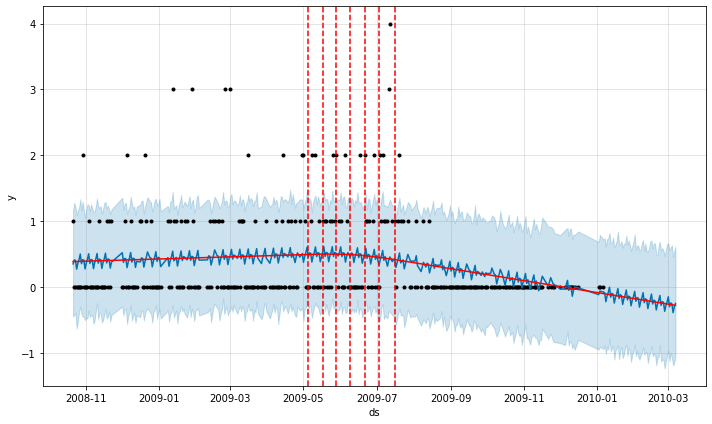

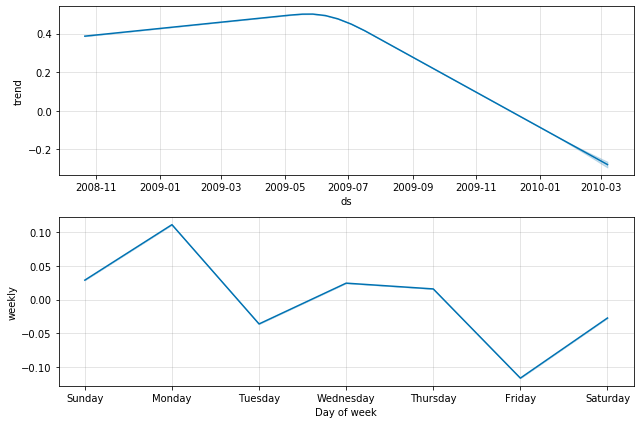

In [15]:
# plot change point for additive
fig_add = model_add.plot(forecast_add)
a = add_changepoints_to_plot(
    fig_add.gca(), model_add, forecast_add
)
fig_add_com = model_add.plot_components(forecast_add)

In [16]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

!wget https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv

--2020-01-11 21:00:59--  https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1745 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv’

AirPassengers.csv   100%[===================>]   1.70K  --.-KB/s    in 0s      

2020-01-11 21:00:59 (297 MB/s) - ‘AirPassengers.csv’ saved [1745/1745]



In [17]:
# load dataset and reformat
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'],  
                             format='%Y-%m-%d')

print(df.isnull().sum())

Month          0
#Passengers    0
dtype: int64


In [18]:
# rename columns as required in Prophet
column_name_1, column_name_2 = df.columns
df.rename(
    columns={column_name_1: 'ds', column_name_2: 'y'},
    inplace=True)

print(df.head())

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(648x432)


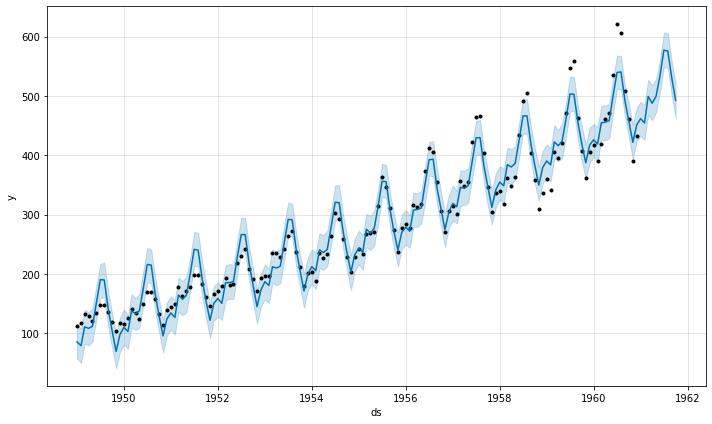

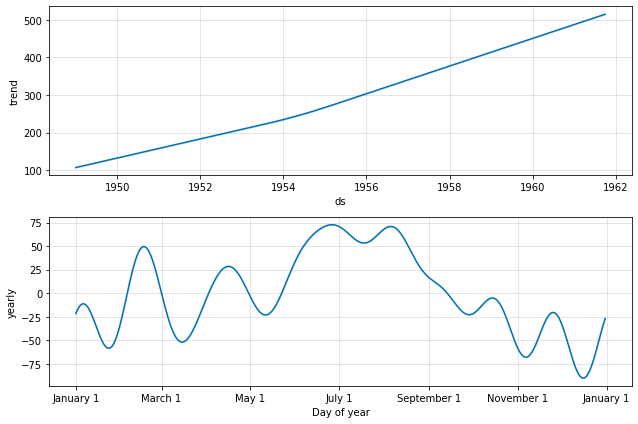

In [19]:
# additive seasonality
model = Prophet().fit(df)

# predict and plot
future = model.make_future_dataframe(periods=10, freq='M')
forecast = model.predict(future)
fig1 = model.plot(forecast)

# plot components
fig2 = model.plot_components(forecast)
print(fig2)

[[<matplotlib.lines.Line2D object at 0x7f7b7f47e278>], <matplotlib.lines.Line2D object at 0x7f7b836eee80>, <matplotlib.lines.Line2D object at 0x7f7b836eb4a8>, <matplotlib.lines.Line2D object at 0x7f7b836eeb38>, <matplotlib.lines.Line2D object at 0x7f7b836ee080>, <matplotlib.lines.Line2D object at 0x7f7b83706080>]


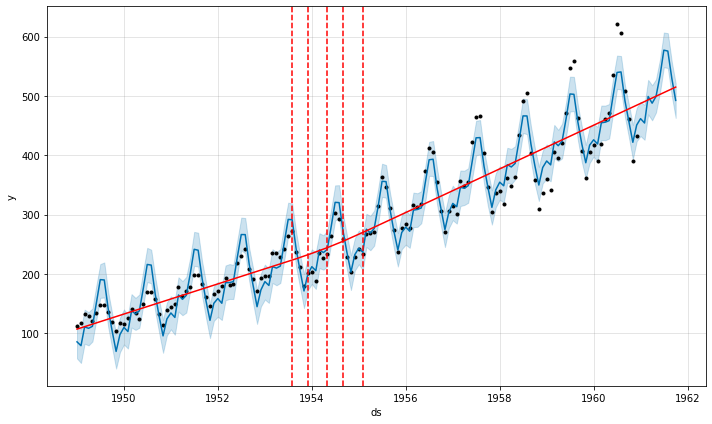

In [20]:
# change-point analysis
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
print(add_changepoints_to_plot(fig.gca(), model, forecast))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Figure(720x432)
Figure(648x432)


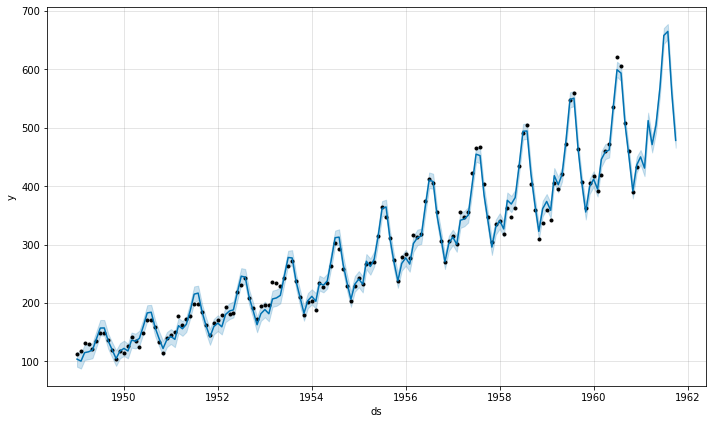

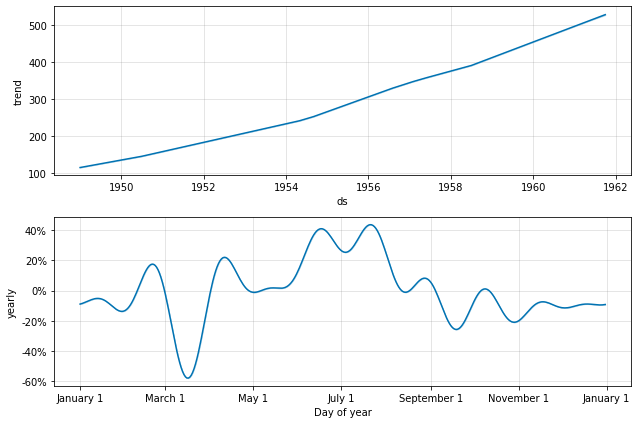

In [21]:
# multiplicable seasonality
model = Prophet(seasonality_mode='multiplicative').fit(df)

# predict and plot
future = model.make_future_dataframe(periods=10, freq='M')
forecast = model.predict(future)
fig3 = model.plot(forecast)
print(fig3)

fig4 = model.plot_components(forecast)
print(fig4)

[[<matplotlib.lines.Line2D object at 0x7f7b8371de48>], <matplotlib.lines.Line2D object at 0x7f7b868b7c88>, <matplotlib.lines.Line2D object at 0x7f7b868b7e10>, <matplotlib.lines.Line2D object at 0x7f7b838769b0>, <matplotlib.lines.Line2D object at 0x7f7b83893518>, <matplotlib.lines.Line2D object at 0x7f7b868d9048>, <matplotlib.lines.Line2D object at 0x7f7b868d97f0>, <matplotlib.lines.Line2D object at 0x7f7b868d9be0>]


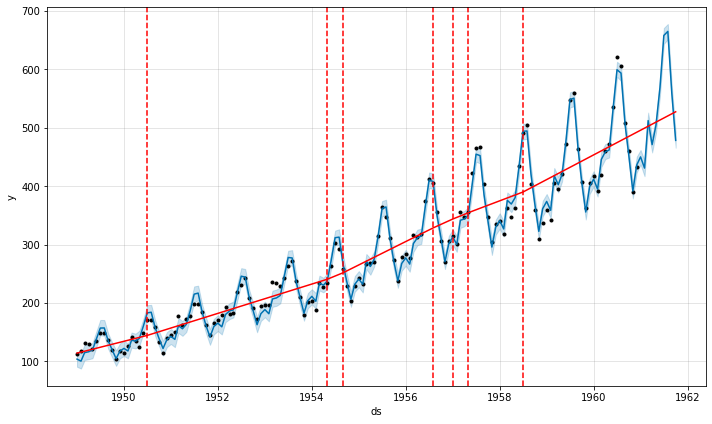

In [22]:
fig = model.plot(forecast)
print(add_changepoints_to_plot(fig.gca(), model, forecast))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


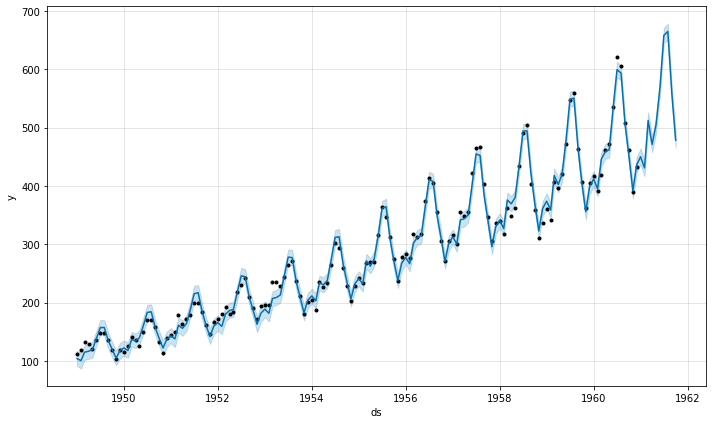

In [23]:
# remove outliers on multiplicative
m = Prophet(seasonality_mode='multiplicative').fit(df)
fig = m.plot(m.predict(future))